In [ ]:
#backup
import random
import time

def buildFactorBase(Q, P, orderP):
    factorBaseSize = ceil(orderP**(1/3))
    factorBase = []
    coord = []
    filled=0
    while filled < factorBaseSize:
        a = Integer(random.random()*orderP) #a in [0, orderE - 1]
        b = Integer(random.random()*orderP)
        cand=a*P+b*Q
        if cand not in factorBase:
            factorBase.append(cand)
            coord.append((a,b))
            filled += 1
    return coord, factorBase
#k.<a>=FiniteField(3^3, modulus=x^3-x-1)
#q.<b>=FiniteField(3^3, modulus=x^3-x+1)

def sumInF(coord, factorBase, orderP):
    length = len(factorBase)
    for i in range(0,length):
        for j in range(i+1,length):
            dp=[factorBase[i], factorBase[j]]
            for v in VectorSpace(GF(2),2):
                #test=[-factorBase[i] if v[0] else factorBase[i]]
                #test+=[-factorBase[j] if v[1] else factorBase[j]]
                test=sum((-1)^v[k]*dp[k] for k in range(0,2)) #simplify
                try:
                    id = factorBase.index(test)
#                     print("coord:",coord[id])
#                     print("v:",v)
#                     print("i,j", coord[i], coord[j])
#                     b = coord[id][1] 
#                     a = -coord[id][0] #a=(a_1 + a_2 - g_1)
#                     b += coord[i][1] if v[0] else -coord[i][1] + coord[j][1] if v[1] else -coord[j][1]
#                     a -= coord[i][0] if v[0] else -coord[i][0] + coord[j][0] if v[1] else -coord[j][0] 
                    b = coord[id][1] 
                    a = -coord[id][0] #a=(a_1 + a_2 - g_1)
                    if v[0]:
                        b+=coord[i][1]
                        a-=coord[i][0]
                    else:
                        b-=coord[i][1]
                        a+=coord[i][0]
                    
                    if v[1]:
                        b+=coord[j][1]
                        a-=coord[j][0]
                    else:
                        b-=coord[j][1]
                        a+=coord[j][0]
                    try:
                        res=mod(a*inverse_mod(b, orderP), orderP)
#                        print(a,b)
                        return res
                    except ZeroDivisionError: #inverse of 'b' does not exist
                        pass
                except ValueError:
                    pass
    return -1
                
#prime
#11 | 13 | 17 | 19 | 23 | 29 | 31 | 37 | 41 | 43 | 47 | 53 | 59 | 61 | 67 | 71 | 73 | 79 | 83 | 89 | 97
p=23
T.<a> = GF(2**p)
while True:
    coefs = [] 
    for i in range(0,5):
        coefs.append( (int)(random.random() >= 0.5) )
    try:
        E = EllipticCurve(T, coefs)
        break
    except ArithmeticError: #if E singular
        pass
print(E)
P=E.gen(0) #base point P
orderP=P.order()
print("Order of P is {}.".format(orderP))

#Q = kP
k=(int)(1+(orderP-1)*random.random()) #k in [1, orderP-1]
Q=k*P
# print(P)
# print(Q)
# print(coord)

# print(factorBase)
attempts=0

start = time.time()
r1=discrete_log(Q,P, E.order(), operation='+')
print("It took {:4.4f} seconds. True answer: {}, Sage_algo_answer: {}."\
      .format((time.time()-start), k, r1))
print("Factorization of Elliptic curve order: {} = {}".format(orderP, orderP.factor()))
start = time.time()
while True:
    coord, factorBase = buildFactorBase(Q, P, orderP)
    attempts += 1
#    if mod(attempts,20) == 1:
    print("Attempt {}, Factor base of size {} builded.".format(attempts, len(factorBase)) )
    res=sumInF(coord, factorBase, orderP)
    if res != -1 or attempts > 1e3:
        break
print("It took {} attempts and {:4.4f} seconds. True answer: {}, algo_answer: {}."\
      .format(attempts,(time.time()-start), k, res))

In [26]:
# import io, os, sys, types
# from IPython import get_ipython
# from nbformat import read
# from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = fullname#find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

            # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


            # create the module and add it to sys.modules
            # if name in sys.modules:
            #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

            # extra work to ensure that magics that would affect the user_ns
            # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

# nb = NotebookLoader("/Users/Maty/Google Drive/DIPLOMKA/ecdlp-diplomka/Sage_implementation/")
# nb.load_module("EC_over_prime_field .ipynb")
load("EC.sage")
# import os
# cwd = os.getcwd()
# print(cwd)

Elliptic Curve defined by y^2 = x^3 + 47842*x + 45768 over Finite Field of size 131101
result: 97385
Order of P is 131001.
Factorization of Elliptic curve order: 131001 = 3 * 13 * 3359
Factorization base of lenght 51 built.


KeyboardInterrupt: 

In [2]:
multiplicative_order??

In [6]:
a = mod(11,12)
print(a.multiplicative_order())
    

2


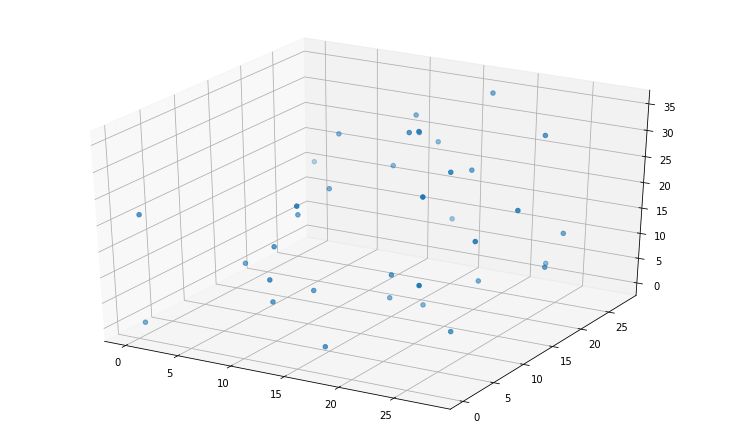

In [43]:
T=GF(29)
E = EllipticCurve(T, [0,0,0,1,1])
g = E.gen(0)
o = g.order()
fg=[(((k*g)[0], (k*g)[1], k)) for k in range(0, o)]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import rc
fig = plt.figure()
fig.set_figwidth(25.0/2.54)
fig.set_figheight(15.0/2.54)
ax = axes3d.Axes3D(fig)
ax.scatter3D(*zip(*fg))

In [31]:
import random
def generateRandomE(p, primeOrd=False):
    T = GF(p)
    
    #general Weierstrass: Y^2 + a1*XY + a3*Y = X^3 + a2*X^2 + a4*X + a6

    #here we can use short Weierstrass eq char(T) = p
    #Y^2 = X^3 + A*X + B, A, B \in GF(p), 
    
    coefs = [0, 0, 0, 1, 1]
    while True:
        #random A
        coefs[3] = T.random_element();
        #random B
        coefs[4] = T.random_element();
        try:
            E = EllipticCurve(T, coefs)
            if primeOrd == False or is_prime(E.order()):
                break
        except ArithmeticError: #if E singular
            pass
    print(E)
    return E



T=GF(29)
E = EllipticCurve(T, [0,0,0,1,1])
print(E)
P = E.gen(0)
orderP = P.order()
n=ceil(sqrt(orderP))
for i in range(0,n):
    print("i = {}, iP = {}".format(i, i*P))
print(orderP, n)
Q=29*P
print(-P)
for i in range(0,n):
    print("j = {}, rs = {}".format(i, Q+((-6*i)*P)))
    
    #polard rho
E = generateRandomE(29, True)
P = E.gen(0)
orderP = P.order()
print()

Elliptic Curve defined by y^2 = x^3 + x + 1 over Finite Field of size 29
i = 0, iP = (0 : 1 : 0)
i = 1, iP = (24 : 25 : 1)
i = 2, iP = (6 : 7 : 1)
i = 3, iP = (0 : 28 : 1)
i = 4, iP = (10 : 24 : 1)
i = 5, iP = (28 : 12 : 1)
(36, 6)
(24 : 4 : 1)
j = 0, rs = (18 : 15 : 1)
j = 1, rs = (11 : 3 : 1)
j = 2, rs = (12 : 1 : 1)
j = 3, rs = (8 : 17 : 1)
j = 4, rs = (28 : 12 : 1)
j = 5, rs = (24 : 4 : 1)
Elliptic Curve defined by y^2 = x^3 + 11*x + 18 over Finite Field of size 29


In [32]:
TT=E

In [83]:
p=29
E = EllipticCurve(GF(p), [0,0,0,11,18])
P = E.gen(0)
Q = 17*P
orderP = P.order()
FF = GF(orderP)
print(P, orderP)

def cntSets(s1,s2,s3, Ti, p):
    bnd = int(floor(p/3))
    if (Ti[0] < bnd): #S1
        s1 += 1;
    elif (Ti[0] >= bnd and Ti[0] < 2*bnd): #S2
        s2 += 1;
    else: #S3
        s3 += 1;
    return s1,s2,s3


def fx(P, Q, p, Ti, ai, bi):
    bnd = int(floor(p/3))
    if (Ti[0] < bnd): #S1
        ai += 1;
        res = P + Ti;
    elif (Ti[0] >= bnd and Ti[0] < 2*bnd): #S2
        ai *= 2;
        bi *= 2;
        res = 2*Ti
    else: #S3
        bi += 1;
        res = Q + Ti;
    return res, ai, bi

totalIt = 0;
for k in range(0,orderP):
    Q=17*P
    it = 0;
    #init
    ai = FF(0)
    bi = FF(0)
    Ti = E(0)
    Ri = E(0)
    ci = FF(0)
    di = FF(0)
    while True:
        print("Ti: {}, Ri: {}, ai: {}, bi: {}, ci: {}, di: {}".format(Ti,Ri,ai,bi,ci,di))
        it += 1;
        if (Ti == Ri):
            #print("match:",ai,bi,ci,di)
            try:
                res = (ci-ai)*(bi-di)^(-1)
                print("result: {}, iter: {}".format(res, it))
                totalIt += it
                break
            except:
                print("Zero division.")
        Ti,ai,bi = fx(P,Q,p,Ti,ai,bi);
        # 2 iterations
        Ri,ci,di = fx(P,Q,p,Ri,ci,di);
        Ri,ci,di = fx(P,Q,p,Ri,ci,di);
    break

print("avg it: {}".format(float(totalIt/orderP))) 
s1=0
s2=0
s3=0
for k in range(0, orderP):
    s1,s2,s3 = cntSets(s1,s2,s3,k*P, p)
print(s1,s2,s3,orderP)
print(Q)

((1 : 1 : 1), 29)
Ti: (0 : 1 : 0), Ri: (0 : 1 : 0), ai: 0, bi: 0, ci: 0, di: 0
Zero division.
Ti: (1 : 1 : 1), Ri: (18 : 25 : 1), ai: 1, bi: 0, ci: 2, di: 0
Ti: (18 : 25 : 1), Ri: (3 : 22 : 1), ai: 2, bi: 0, ci: 3, di: 1
Ti: (5 : 13 : 1), Ri: (11 : 7 : 1), ai: 2, bi: 1, ci: 8, di: 2
Ti: (3 : 22 : 1), Ri: (8 : 3 : 1), ai: 3, bi: 1, ci: 3, di: 8
Ti: (12 : 14 : 1), Ri: (13 : 3 : 1), ai: 4, bi: 1, ci: 4, di: 9
Ti: (11 : 7 : 1), Ri: (13 : 3 : 1), ai: 8, bi: 2, ci: 8, di: 19
Ti: (14 : 4 : 1), Ri: (13 : 3 : 1), ai: 16, bi: 4, ci: 16, di: 10
Ti: (8 : 3 : 1), Ri: (13 : 3 : 1), ai: 3, bi: 8, ci: 3, di: 21
Ti: (26 : 25 : 1), Ri: (13 : 3 : 1), ai: 4, bi: 8, ci: 6, di: 14
Ti: (13 : 3 : 1), Ri: (13 : 3 : 1), ai: 4, bi: 9, ci: 12, di: 0
result: 17, iter: 11
avg it: 0.379310344828
(9, 12, 8, 29)
(13 : 26 : 1)


In [90]:
17*P

(13 : 26 : 1)